In [1]:
!pip install Sastrawi

In [2]:
import pandas as pd
import numpy as np

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [3]:
df_paspor = pd.read_csv('17plus8.csv')

In [4]:
df_paspor.head(10)

,Username,Name,Tweet Text,Tweet URL,Created at
0,jasutopia1,Jasutopia,17+8 Tuntutan RAKYAT\n\n#TuntutanRakyat #17plu...,https://twitter.com/jasutopia1/status/19636724...,2025-09-04 18:36:20+00:00
1,PETAJakarta,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik\nAnak muda dipak...,https://twitter.com/PETAJakarta/status/1966671...,2025-09-13 01:12:17+00:00
2,pengenjadiraftr,Pengen Jadi Rafathar,17+8\n#178TuntutanRakyat #17Plus8 #TuntutanRak...,https://twitter.com/pengenjadiraftr/status/196...,2025-09-07 11:40:11+00:00
3,RezaAnugrah_03,Ca,"Demo se cutesy ini, awas aja ada yang nuduh ma...",https://twitter.com/RezaAnugrah_03/status/1964...,2025-09-06 05:46:56+00:00
4,panggung2024,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,2025-09-03 09:05:37+00:00
5,Bercahayanew,bercahaya news,Prabowo menanggapi isu 17+8 dan menilai sejuml...,https://twitter.com/Bercahayanew/status/196531...,2025-09-09 07:10:14+00:00
6,DiskursusNet,Diskursus Network,"Ahli Fisika dan Matematika ITB, Alif Towew sus...",https://twitter.com/DiskursusNet/status/196895...,2025-09-19 08:33:45+00:00
7,Zibon_Update,ZIBON UPDATE,Presiden Prabowo akhirnya buka suara soal 17+8...,https://twitter.com/Zibon_Update/status/196502...,2025-09-08 11:51:51+00:00
8,DiskursusNet,Diskursus Network,SUPERVISI DAN KONTROL PIMPINAN DI POLRI LEMAH\...,https://twitter.com/DiskursusNet/status/197183...,2025-09-27 07:05:24+00:00
9,DiskursusNet,Diskursus Network,"Pakar Hukum Tata Negara, Feri Amsari nilai ada...",https://twitter.com/DiskursusNet/status/196934...,2025-09-20 10:00:01+00:00


In [5]:
df_paspor['Username'] = df_paspor['Username'].astype(str)
df_paspor['Name'] = df_paspor['Name'].astype(str)
df_paspor['Tweet Text'] = df_paspor['Tweet Text'].astype(str)
df_paspor['Tweet URL'] = df_paspor['Tweet URL'].astype(str)
df_paspor['Created at'] = pd.to_datetime(df_paspor['Created at'])

In [6]:
column_dtypes = df_paspor.dtypes
print(column_dtypes)

Username                   object
Name                       object
Tweet Text                 object
Tweet URL                  object
Created at    datetime64[ns, UTC]
dtype: object


In [32]:
# Set the start and end date range
start_date = pd.to_datetime('2025-08-01').tz_localize('Asia/Jakarta')
end_date = pd.to_datetime('2025-10-30').tz_localize('Asia/Jakarta')

# Filter the DataFrame for data within the specified date range
df_ytd = df_paspor[(df_paspor['Created at'] >= start_date) & (df_paspor['Created at'] <= end_date)]

In [31]:
num_records = len(df_ytd)
print("Number of records in df_ytd:", num_records)

Number of records in df_ytd: 77


In [34]:
start_date = df_ytd['Created at'].min()
end_date = df_ytd['Created at'].max()

print("Start Date:", start_date)
print("End Date:", end_date)


Start Date: 2025-08-12 04:59:11+00:00
End Date: 2025-10-15 11:34:29+00:00


In [35]:
df_textPreprocessing = df_ytd.copy()

# NOW PREPROCESS THE MAKE THE PREDICTION

In [36]:
num_records = len(df_textPreprocessing)
print("Number of records in df_textPreprocessing:", num_records)

Number of records in df_textPreprocessing: 77


In [37]:
columns_to_drop = ['Username', 'Created at']
df_textPreprocessing = df_textPreprocessing.drop(columns=columns_to_drop)

In [38]:
df_textPreprocessing.tail(10)

,Name,Tweet Text,Tweet URL
98,mudanews,"Ketika Rakyat Pati - Jawa Tengah Melawan (3), ...",https://twitter.com/mudanewscom/status/1955660...
99,mudanews,"Ketika Rakyat Pati - Jawa Tengah Melawan (2), ...",https://twitter.com/mudanewscom/status/1955627...
101,Anti 🚫NEOPKI,Asiknya NKRI kompak dalam KORUPSI sebetulnya m...,https://twitter.com/van88xier/status/196670379...
103,Ichsan W Lubis,Semakin kesini semakin kesana.\n.\n.\n.\n#indo...,https://twitter.com/ichsan_wardana/status/1961...
104,Dokter Tifa,Seminggu lagi akan tambah 1/4 INDONESIA lagi\n...,https://twitter.com/DokterTifa/status/19639084...
106,Cah Angon 🇮🇩,"Pati malam ini\n\nRakyat Bersatu, Rakyat Kuat\...",https://twitter.com/CahAngo45022699/status/195...
110,Cah Angon 🇮🇩,Siapa yg bikin system? 🙄\nSystem yg mencekik r...,https://twitter.com/CahAngo45022699/status/195...
111,Nirmala,Puas rasanya liat mba di video ini. Tapi meras...,https://twitter.com/Nirmala787/status/19569499...
112,Cah Angon 🇮🇩,Revolusi berawal dari Pati dilanjutkan ke Jati...,https://twitter.com/CahAngo45022699/status/195...
115,[wong clayten],Coward! \n#IndonesiaGelap \n#affankurniawan \n...,https://twitter.com/wong_clayten/status/196128...


In [39]:
#remove punctuations
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace('[^\w]|_',' ')

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3994149357.py:2: SyntaxWarning: invalid escape sequence '\w'
  df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace('[^\w]|_',' ')


In [40]:
#remove digit or numbers
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace("\d+", " ")

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1446038192.py:2: SyntaxWarning: invalid escape sequence '\d'
  df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace("\d+", " ")


In [41]:
#remove word with digit
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace("\S*\d\S*", " ")

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-558749996.py:2: SyntaxWarning: invalid escape sequence '\S'
  df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace("\S*\d\S*", " ")


In [42]:
#Remove additional white spaces
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace('[\s]+', ' ')

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1556028408.py:2: SyntaxWarning: invalid escape sequence '\s'
  df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace('[\s]+', ' ')


In [43]:
# Define the normalization mapping based on KBBI
normalization_mapping = {
    'di': 'di',
    'ini': 'ini',
    'dan': 'dan',
    'ok': 'bagus',
    'nya': 'nya',
    'aku': 'aku',
    'Ok': 'bagus',
    'ada': 'ada',
    'tik': 'tik',
    'Aku': 'aku',
    'yg': 'yang',
    'gak': 'tidak',
    'ga': 'tidak',
    'ku': 'kamu',
    'the': 'the',
    'ya': 'ya',
    '5': 'lima',
    'aja': 'saja',
    'I': 'saya',
    'apk': 'aplikasi',
    '👍': 'bagus',
    'ke': 'ke',
    'mau': 'mau',
    'you': 'kamu',
    'kok': 'kok',
    'gk': 'tidak',
    'fyp': 'fyp',
    'sih': 'sih',
    'apa': 'apa',
    'Apk': 'aplikasi',
    'd': 'di',
    'app': 'aplikasi',
    'itu': 'itu',
    'ok': 'bagus',
    'lah': 'lah',
    'bgt': 'banget',
    'to': 'ke',
    '3': 'tiga',
    'is': 'adalah',
    'ko': 'kamu',
    'Ini': 'ini',
    'nia': 'nia',
    'and': 'dan',
    '2': 'dua',
    'hp': 'handphone',
    'kan': 'kan',
    'deh': 'deh',
    'Top': 'bagus',
    'gua': 'saya',
    'Oke': 'bagus',
    'my': 'saya',
    'i': 'saya',
    'ny': 'nya',
    'dgn': 'dengan',
    'Top.': 'bagus',
    'dagus': 'bagus',
    'bs': 'bisa',
    'senagsekali': 'senang sekali',
    'ferbaiki': 'perbaiki',
    'waifi': 'wifi',
    'The best': 'terbaik',
    'Mantab': 'mantap',
    'bgus': 'bagus',
    'Ko': 'kamu',
    'bgt': 'banget',
    'knp': 'kenapa',
    'jgn': 'jangan',
    'gtw': 'enggak tahu',
    'bsk': 'besok',
    'lgsg': 'langsung',
    'y': 'ya',
    'jg': 'juga',
    'tp': 'tapi',
    'trs': 'terus',
    'jd': 'jadi',
    'pdhl': 'padahal',
    'blm': 'belum',
    'dpt': 'dapat',
    'gk': 'gak',
    'bb': 'badan',
    'mgkn': 'mungkin',
    'sm': 'sama',
    'bngt': 'banget',
    'sgt': 'sangat',
    'gaul': 'keren',
    'cuy': 'bro',
    'mantap': 'bagus',
    'ngab': 'bro',
    'asem': 'asli semangat',
    'pake': 'pakai',
    'mabar': 'main bareng',
    'lahir batin': 'sepenuh hati',
    'tolol': 'bodoh',
    'baper': 'bawa perasaan',
    'wkwk': 'haha',
    'abis': 'habis',
    'wibu': 'penggemar budaya Jepang',
    'asyikkk': 'asyik',
    'baguus': 'bagus',
    'selaluih': 'selalu',
    'mmantap': 'mantap',
    'stabilo': 'stabil',
    'terbaikk': 'terbaik',
    'percumaa': 'percuma',
    'mahall': 'mahal',
    'manstap': 'mantap',
    'terbainya': 'terbaiknya',
    'malahh': 'malah',
    'tulusin': 'tuluskan',
    'gadaa': 'gak ada',
    'tok': 'tiktok',
    'menyedot': 'menghisap',
    'good': 'bagus',
    'bagu': 'bagus'

}

# Function to perform manual normalization
def normalize_text(text):
    normalized_text = []
    words = text.split()
    for word in words:
        if word in normalization_mapping:
            normalized_word = normalization_mapping[word]
            normalized_text.append(normalized_word)
        else:
            normalized_text.append(word)
    normalized_text = ' '.join(normalized_text)
    return normalized_text

# Apply the text normalization function to the 'content' column
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].apply(normalize_text)

In [44]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...


In [45]:
def case_folding(review):
    # Convert the review to lowercase
    folded_review = review.lower()
    return folded_review

df_textPreprocessing['folded_content'] = df_textPreprocessing['Tweet Text'].apply(case_folding)


In [46]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL,folded_content
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...,17+8 tuntutan rakyat #tuntutanrakyat #17plus8 ...
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...,bahaya latent (fakta) politik anak muda dipaks...
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...,17+8 #178tuntutanrakyat #17plus8 #tuntutanraky...
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...,"demo se cutesy ini, awas saja ada yang nuduh m..."
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,"“17+8 tuntutan rakyat” jelas: tarik tni, usut ..."


In [47]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')
# Additional stop words
more_stopword = ['#', 'shopee','https','t','co', 'tco', 't co', 'sy','nya','n','bgt','banget','d','bu','pak','dengan','dgn','kemaren','kmrin','dear','yth','ass','gak','ny','cari','dibantu','mohon','saja','aja','malam','selamat','sore','siang','pagi','asalamualaikum','wb','wr','assalamualaikum','sya','yg', 'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan', 'berkenaan', 'berlainan', 'berlalu', 'berlangsung', 'berlebihan', 'bermacam', 'bermacam-macam', 'bermaksud', 'bermula', 'bersama', 'bersama-sama', 'bersiap', 'bersiap-siap', 'bertanya', 'bertanya-tanya', 'berturut', 'berturut-turut', 'bertutur', 'berujar', 'berupa', 'besar', 'betul', 'betulkah', 'biasa', 'biasanya', 'bila', 'bilakah', 'bisa', 'bisakah', 'boleh', 'bolehkah', 'bolehlah', 'buat', 'bukan', 'bukankah', 'bukanlah', 'bukannya', 'bulan', 'bung', 'cara', 'caranya', 'cukup', 'cukupkah', 'cukuplah', 'cuma', 'dahulu', 'dalam', 'dan', 'dapat', 'dari', 'daripada', 'datang', 'dekat', 'demi', 'demikian', 'demikianlah', 'dengan', 'depan', 'di', 'dia', 'diakhiri', 'diakhirinya', 'dialah', 'diantara', 'diantaranya', 'diberi', 'diberikan', 'diberikannya', 'dibuat', 'dibuatnya', 'didapat', 'didatangkan', 'digunakan', 'diibaratkan', 'diibaratkannya', 'diingat', 'diingatkan', 'diinginkan', 'dijawab', 'dijelaskan', 'dijelaskannya', 'dikarenakan', 'dikatakan', 'dikatakannya', 'dikerjakan', 'diketahui', 'diketahuinya', 'dikira', 'dilakukan', 'dilalui', 'dilihat', 'dimaksud', 'dimaksudkan', 'dimaksudkannya', 'dimaksudnya', 'diminta', 'dimintai', 'dimisalkan', 'dimulai', 'dimulailah', 'dimulainya', 'dimungkinkan', 'dini', 'dipastikan', 'diperbuat', 'diperbuatnya', 'dipergunakan', 'diperkirakan', 'diperlihatkan', 'diperlukan', 'diperlukannya', 'dipersoalkan', 'dipertanyakan', 'dipunyai', 'diri', 'dirinya', 'disampaikan', 'disebut', 'disebutkan', 'disebutkannya', 'disini', 'disinilah', 'ditambahkan', 'ditandaskan', 'ditanya', 'ditanyai', 'ditanyakan', 'ditegaskan', 'ditujukan', 'ditunjuk', 'ditunjuki', 'ditunjukkan', 'ditunjukkannya', 'ditunjuknya', 'dituturkan', 'dituturkannya', 'diucapkan', 'diucapkannya', 'diungkapkan', 'dong', 'dua', 'dulu', 'empat', 'enggak', 'enggaknya', 'entah', 'entahlah', 'guna', 'gunakan', 'hal', 'hampir', 'hanya', 'hanyalah', 'hari', 'harus', 'haruslah', 'harusnya', 'hendak', 'hendaklah', 'hendaknya', 'hingga', 'ia', 'ialah', 'ibarat', 'ibaratkan', 'ibaratnya', 'ibu', 'ikut', 'ingat', 'ingat-ingat', 'ingin', 'inginkah', 'inginkan', 'ini', 'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi', 'jadilah', 'jadinya', 'jangan', 'jangankan', 'janganlah', 'jauh', 'jawab', 'jawaban', 'jawabnya', 'jelas', 'jelaskan', 'jelaslah', 'jelasnya', 'jika', 'jikalau', 'juga', 'jumlah', 'jumlahnya', 'justru', 'kala', 'kalau', 'kalaulah', 'kalaupun', 'kalian', 'kami', 'kamilah', 'kamu', 'kamulah', 'kan', 'kapan', 'kapankah', 'kapanpun', 'karena', 'karenanya', 'kasus', 'kata', 'katakan', 'katakanlah', 'katanya', 'ke', 'keadaan', 'kebetulan', 'kecil', 'kedua', 'keduanya', 'keinginan', 'kelamaan', 'kelihatan', 'kelihatannya', 'kelima', 'keluar', 'kembali', 'kemudian', 'kemungkinan', 'kemungkinannya', 'kenapa', 'kepada', 'kepadanya', 'kesampaian', 'keseluruhan', 'keseluruhannya', 'keterlaluan', 'ketika', 'khususnya', 'kini', 'kinilah', 'kira', 'kira-kira', 'kiranya', 'kita', 'kitalah', 'kok', 'kurang', 'lagi', 'lagian', 'lah', 'lain', 'lainnya', 'lalu', 'lama', 'lamanya', 'lanjut', 'lanjutnya', 'lebih', 'lewat', 'lima', 'luar', 'macam', 'maka', 'makanya', 'makin', 'malah', 'malahan', 'mampu', 'mampukah', 'mana', 'manakala', 'manalagi', 'masa', 'masalah', 'masalahnya', 'masih', 'masihkah', 'masing', 'masing-masing', 'mau', 'maupun', 'melainkan', 'melakukan', 'melalui', 'melihat', 'melihatnya', 'memang', 'memastikan', 'memberi', 'memberikan', 'membuat', 'memerlukan', 'memihak', 'meminta', 'memintakan', 'memisalkan', 'memperbuat', 'mempergunakan', 'memperkirakan', 'memperlihatkan', 'mempersiapkan', 'mempersoalkan', 'mempertanyakan', 'mempunyai', 'memulai', 'memungkinkan', 'menaiki', 'menambahkan', 'menandaskan', 'menanti', 'menanti-nanti', 'menantikan', 'menanya', 'menanyai', 'menanyakan', 'mendapat', 'mendapatkan', 'mendatang', 'mendatangi', 'mendatangkan', 'menegaskan', 'mengakhiri', 'mengapa', 'mengatakan', 'mengatakannya', 'mengenai', 'mengerjakan', 'mengetahui', 'menggunakan', 'menghendaki', 'mengibaratkan', 'mengibaratkannya', 'mengingat', 'mengingatkan', 'menginginkan', 'mengira', 'mengucapkan', 'mengucapkannya', 'mengungkapkan', 'menjadi', 'menjawab', 'menjelaskan', 'menuju', 'menunjuk', 'menunjuki', 'menunjukkan', 'menunjuknya', 'menurut', 'menuturkan', 'menyampaikan', 'menyangkut', 'menyatakan', 'menyebutkan', 'menyeluruh', 'menyiapkan', 'merasa', 'mereka', 'merekalah', 'merupakan', 'meski', 'meskipun', 'meyakini', 'meyakinkan', 'minta', 'mirip', 'misal', 'misalkan', 'misalnya', 'mula', 'mulai', 'mulailah', 'mulanya', 'mungkin', 'mungkinkah', 'nah', 'naik', 'namun', 'nanti', 'nantinya', 'nyaris', 'nyatanya', 'oleh', 'olehnya', 'pada', 'padahal', 'padanya', 'pak', 'paling', 'panjang', 'pantas', 'para', 'pasti', 'pastilah', 'penting', 'pentingnya', 'per', 'percuma', 'perlu', 'perlukah', 'perlunya', 'pernah', 'persoalan', 'pertama', 'pertama-tama', 'pertanyaan', 'pertanyakan', 'pihak', 'pihaknya', 'pukul', 'pula', 'pun', 'punya', 'rasa', 'rasanya', 'rata', 'rupanya', 'saat', 'saatnya', 'saja', 'sajalah', 'saling', 'sama', 'sama-sama', 'sambil', 'sampai', 'sampai-sampai', 'sampaikan', 'sana', 'sangat', 'sangatlah', 'satu', 'saya', 'sayalah', 'se', 'sebab', 'sebabnya', 'sebagai', 'sebagaimana', 'sebagainya', 'sebagian', 'sebaik', 'sebaik-baiknya', 'sebaiknya', 'sebaliknya', 'sebanyak', 'sebegini', 'sebegitu', 'sebelum', 'sebelumnya', 'sebenarnya', 'seberapa', 'sebesar', 'sebetulnya', 'sebisanya', 'sebuah', 'sebut', 'sebutlah', 'sebutnya', 'secara', 'secukupnya', 'sedang', 'sedangkan', 'sedemikian', 'sedikit', 'sedikitnya', 'seenaknya', 'segala', 'segalanya', 'segera', 'seharusnya', 'sehingga', 'seingat', 'sejak', 'sejauh', 'sejenak', 'sejumlah', 'sekadar', 'sekadarnya', 'sekali', 'sekali-kali', 'sekalian', 'sekaligus', 'sekalipun', 'sekarang', 'sekarang', 'sekecil', 'seketika', 'sekiranya', 'sekitar', 'sekitarnya', 'sekurang-kurangnya', 'sekurangnya', 'sela', 'selain', 'selaku', 'selalu', 'selama', 'selama-lamanya', 'selamanya', 'selanjutnya', 'seluruh', 'seluruhnya', 'semacam', 'semakin', 'semampu', 'semampunya', 'semasa', 'semasih', 'semata', 'semata-mata', 'semaunya', 'sementara', 'semisal', 'semisalnya', 'sempat', 'semua', 'semuanya', 'semula', 'sendiri', 'sendirian', 'sendirinya', 'seolah', 'seolah-olah', 'seorang', 'sepanjang', 'sepantasnya', 'sepantasnyalah', 'seperlunya', 'seperti', 'sepertinya', 'sepihak', 'sering', 'seringnya', 'serta', 'serupa', 'sesaat', 'sesama', 'sesampai', 'sesegera', 'sesekali', 'seseorang', 'sesuatu', 'sesuatunya', 'sesudah', 'sesudahnya', 'setelah', 'setempat', 'setengah', 'seterusnya', 'setiap', 'setiba', 'setibanya', 'setidak-tidaknya', 'setidaknya', 'setinggi', 'seusai', 'sewaktu', 'siap', 'siapa', 'siapakah', 'siapapun', 'sini', 'sinilah', 'soal', 'soalnya', 'suatu', 'sudah', 'sudahkah', 'sudahlah', 'supaya', 'tadi', 'tadinya', 'tahu', 'tahun', 'tak', 'tambah', 'tambahnya', 'tampak', 'tampaknya', 'tandas', 'tandasnya', 'tanpa', 'tanya', 'tanyakan', 'tanyanya', 'tapi', 'tegas', 'tegasnya', 'telah', 'tempat', 'tengah', 'tentang', 'tentu', 'tentulah', 'tentunya', 'tepat', 'terakhir', 'terasa', 'terbanyak', 'terdahulu', 'terdapat', 'terdiri', 'terhadap', 'terhadapnya', 'teringat', 'teringat-ingat', 'terjadi', 'terjadilah', 'terjadinya', 'terkira', 'terlalu', 'terlebih', 'terlihat', 'termasuk', 'ternyata', 'tersampaikan', 'tersebut', 'tersebutlah', 'tertentu', 'tertuju', 'terus', 'terutama', 'tetap', 'tetapi', 'tiap', 'tiba', 'tiba-tiba', 'tidak', 'tidakkah', 'tidaklah', 'tiga', 'tinggi', 'toh', 'tunjuk', 'turut', 'tutur', 'tuturnya', 'ucap', 'ucapnya', 'ujar', 'ujarnya', 'umum', 'umumnya', 'ungkap', 'ungkapnya', 'untuk', 'usah', 'usai', 'waduh', 'wah', 'wahai', 'waktu', 'waktunya', 'walau', 'walaupun', 'wong', 'yaitu', 'yakin', 'yakni', 'yang']
# Create a dictionary with the default stop words and your additional stop words
stop_words = set(stopwords.words('indonesian')) | set(more_stopword)

def remove_stop_words(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a string
    return ' '.join(filtered_tokens)

# Apply the function to your DataFrame
df_textPreprocessing['content_without_stopwords'] = df_textPreprocessing['folded_content'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [48]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL,folded_content,content_without_stopwords
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...,17+8 tuntutan rakyat #tuntutanrakyat #17plus8 ...,17+8 tuntutan rakyat tuntutanrakyat 17plus8 re...
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...,bahaya latent (fakta) politik anak muda dipaks...,bahaya latent ( fakta ) politik anak muda dipa...
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...,17+8 #178tuntutanrakyat #17plus8 #tuntutanraky...,17+8 178tuntutanrakyat 17plus8 tuntutanrakyat ...
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...,"demo se cutesy ini, awas saja ada yang nuduh m...","demo cutesy , awas nuduh makar yeee🤏🏻 . acab13..."
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,"“17+8 tuntutan rakyat” jelas: tarik tni, usut ...","“ 17+8 tuntutan rakyat ” : tarik tni , usut ko..."


In [49]:
def tokenize_text(review):
    # Tokenize the review into individual words
    tokens = nltk.word_tokenize(review)
    return tokens

df_textPreprocessing['tokens'] = df_textPreprocessing['content_without_stopwords'].apply(tokenize_text)

In [159]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL,label,folded_content,content_without_stopwords,tokens,stemmed_sentence,sentiment
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...,None,17+8 tuntutan rakyat #tuntutanrakyat #17plus8 ...,17+8 tuntutan rakyat tuntutanrakyat 17plus8 re...,"[17+8, tuntutan, rakyat, tuntutanrakyat, 17plu...",17 8 tuntut rakyat tuntutanrakyat 17plus8 refo...,positive
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...,None,bahaya latent (fakta) politik anak muda dipaks...,bahaya latent ( fakta ) politik anak muda dipa...,"[bahaya, latent, (, fakta, ), politik, anak, m...",bahaya latent fakta politik anak muda paksa ...,positive
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...,None,17+8 #178tuntutanrakyat #17plus8 #tuntutanraky...,17+8 178tuntutanrakyat 17plus8 tuntutanrakyat ...,"[17+8, 178tuntutanrakyat, 17plus8, tuntutanrak...",17 8 178tuntutanrakyat 17plus8 tuntutanrakyat ...,positive
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...,None,"demo se cutesy ini, awas saja ada yang nuduh m...","demo cutesy , awas nuduh makar yeee🤏🏻 . acab13...","[demo, cutesy, ,, awas, nuduh, makar, yeee🤏🏻, ...",demo cutesy awas nuduh makar yeee acab1312 1...,positive
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,None,"“17+8 tuntutan rakyat” jelas: tarik tni, usut ...","“ 17+8 tuntutan rakyat ” : tarik tni , usut ko...","[“, 17+8, tuntutan, rakyat, ”, :, tarik, tni, ...",17 8 tuntut rakyat tarik tni usut korban d...,positive


In [50]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stemmer = StemmerFactory().create_stemmer()

def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_sentence = ' '.join(stemmed_tokens)  # Join tokens with whitespace separator
    return stemmed_sentence

df_textPreprocessing['stemmed_sentence'] = df_textPreprocessing['tokens'].apply(stem_tokens)

In [51]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL,folded_content,content_without_stopwords,tokens,stemmed_sentence
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...,17+8 tuntutan rakyat #tuntutanrakyat #17plus8 ...,17+8 tuntutan rakyat tuntutanrakyat 17plus8 re...,"[17+8, tuntutan, rakyat, tuntutanrakyat, 17plu...",17 8 tuntut rakyat tuntutanrakyat 17plus8 refo...
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...,bahaya latent (fakta) politik anak muda dipaks...,bahaya latent ( fakta ) politik anak muda dipa...,"[bahaya, latent, (, fakta, ), politik, anak, m...",bahaya latent fakta politik anak muda paksa ...
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...,17+8 #178tuntutanrakyat #17plus8 #tuntutanraky...,17+8 178tuntutanrakyat 17plus8 tuntutanrakyat ...,"[17+8, 178tuntutanrakyat, 17plus8, tuntutanrak...",17 8 178tuntutanrakyat 17plus8 tuntutanrakyat ...
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...,"demo se cutesy ini, awas saja ada yang nuduh m...","demo cutesy , awas nuduh makar yeee🤏🏻 . acab13...","[demo, cutesy, ,, awas, nuduh, makar, yeee🤏🏻, ...",demo cutesy awas nuduh makar yeee acab1312 1...
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,"“17+8 tuntutan rakyat” jelas: tarik tni, usut ...","“ 17+8 tuntutan rakyat ” : tarik tni , usut ko...","[“, 17+8, tuntutan, rakyat, ”, :, tarik, tni, ...",17 8 tuntut rakyat tarik tni usut korban d...


In [52]:
!pip install transformers==4.38.2

from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You s

In [ ]:
import torch

# Function to predict sentiment
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class index
    predictions = torch.argmax(outputs.logits, dim=1)

    # Map the index to the corresponding label
    # 0: negative, 1: positive
    sentiment_labels = ['negative', 'positive'] # Assuming this order based on common sentiment analysis output
    return sentiment_labels[predictions.item()]

# Apply the function to your dataframe
# [cite_start]We'll use the 'stemmed_sentence' column as it's the most processed one [cite: 1, 2, 9, 10, 18, 32, 33, 38, 42, 51, 62]
df_textPreprocessing['sentiment'] = df_textPreprocessing['stemmed_sentence'].apply(predict_sentiment)

# Display the results
print(df_textPreprocessing[['stemmed_sentence', 'sentiment']].head(10))

                                    stemmed_sentence sentiment
0  17 8 tuntut rakyat tuntutanrakyat 17plus8 refo...  positive
1  bahaya latent  fakta  politik anak muda paksa ...  positive
2  17 8 178tuntutanrakyat 17plus8 tuntutanrakyat ...  positive
3  demo cutesy  awas nuduh makar yeee  acab1312 1...  negative
4   17 8 tuntut rakyat   tarik tni  usut korban d...  positive
5  prabowo tanggap isu 17 8 nilai tuntut rakyat m...  positive
6  ahli fisika matematika itb  alif towew susun g...  positive
7  presiden prabowo buka suara 17 8 tuntut rakyat...  positive
8  supervisi kontrol pimpin polri lemah alfonsloe...  positive
9  pakar hukum tata negara  feri amsari nilai jan...  positive


# Visualization for  the result

In [86]:
from collections import Counter

# Filter the DataFrame for positive label records
positive_df = df_textPreprocessing[df_textPreprocessing['sentiment'] == 'positive']

# Concatenate all positive reviews into a single string
positive_reviews = ' '.join(positive_df['stemmed_sentence'])

# Tokenize the string into individual words
positive_tokens = nltk.word_tokenize(positive_reviews)

# Count the frequency of each word
word_freq = Counter(positive_tokens)

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Number of top words to retrieve
top_n = 12

# Retrieve the top N words with the highest frequencies
top_words = sorted_word_freq[2:top_n]

# Print the top words and their frequencies
for word, freq in top_words:
    print(word, freq)


resetindonesia 20
rakyat 19
17plus8 17
suararakyat 13
tuntutanrakyat 9
17 8
8 8
tuntut 8
suara 8
polri 8


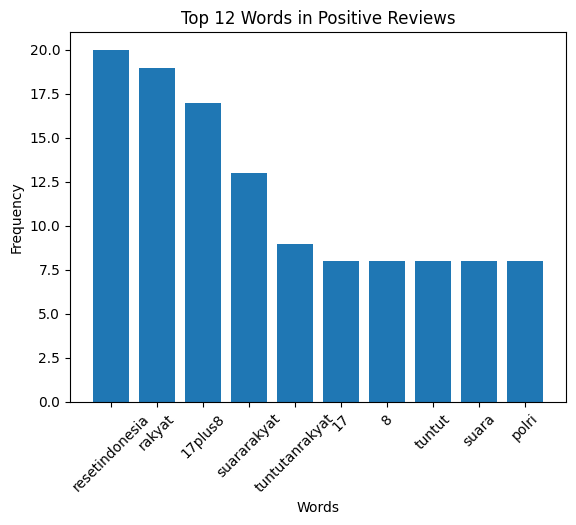

In [87]:
import matplotlib.pyplot as plt

# Retrieve the top N words and their frequencies
top_words = sorted_word_freq[2:top_n]

# Extract the words and frequencies into separate lists
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Create a bar plot
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words in Positive Reviews'.format(top_n))

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()


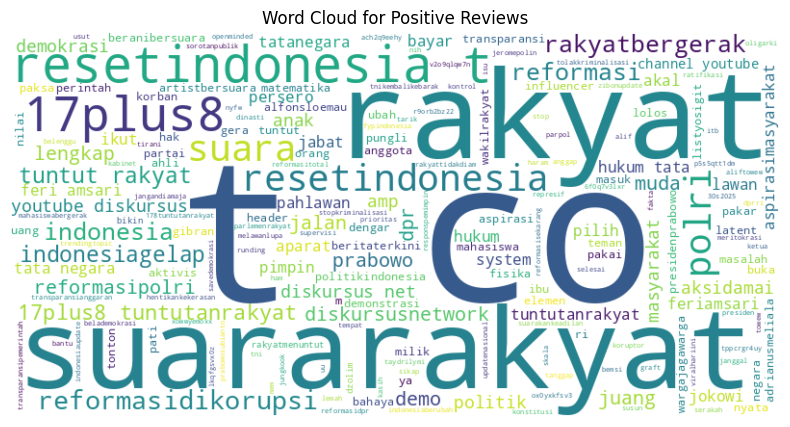

In [90]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for positive label records
positive_df = df_textPreprocessing[df_textPreprocessing['sentiment'] == 'positive']

# Concatenate all positive reviews into a single string
positive_reviews = ' '.join(positive_df['stemmed_sentence'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()


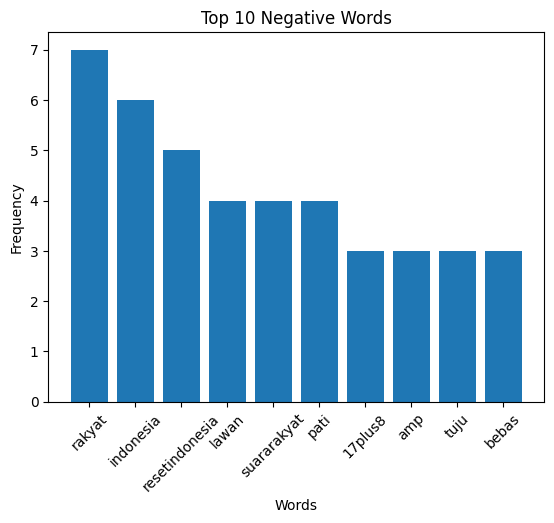

In [63]:
import matplotlib.pyplot as plt
from collections import Counter

# Filter the DataFrame for negative label records
negative_df = df_textPreprocessing[df_textPreprocessing['sentiment'] == 'negative']

# Concatenate all negative reviews into a single string
negative_reviews = ' '.join(negative_df['stemmed_sentence'])

# Tokenize the string into individual words
negative_tokens = nltk.word_tokenize(negative_reviews)

# Count the frequency of each word
word_freq = Counter(negative_tokens)

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Retrieve the top 10 words with the highest frequencies
top_words = sorted_word_freq[2:top_n]

# Extract the words and frequencies for plotting
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Create a bar chart
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Negative Words')
plt.xticks(rotation=45)
plt.show()


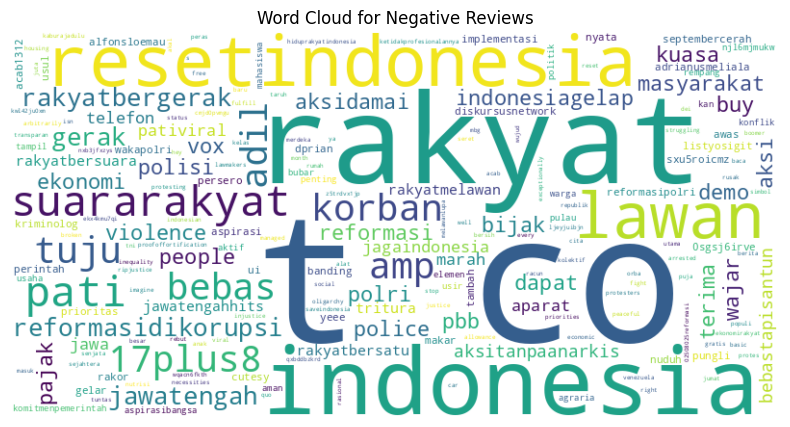

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for negative label records
negative_df = df_textPreprocessing[df_textPreprocessing['sentiment'] == 'negative']

# Concatenate all negative reviews into a single string
negative_reviews = ' '.join(negative_df['stemmed_sentence'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()
